In [1]:
# load all necessary libraries
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# libraries for nlp task
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
#machine learning

from sklearn.svm import SVC
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split,cross_val_score,KFold
# filtering warnings
import warnings
warnings.filterwarnings('ignore')

# Read Dataset

In [2]:
df = pd.read_excel("Project1_data.xlsx")
df.head()

,sentences,sentiments
0,"According to Gran , the company has no plans to move all production to Russia , although that is...",neutral
1,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to...",neutral
2,The international electronic industry company Elcoteq has laid off tens of employees from its Ta...,negative
3,With the new production plant the company would increase its capacity to meet the expected incre...,positive
4,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-te...",positive


# Exploratory Data Analysis (EDA)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14780 entries, 0 to 14779
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentences   14780 non-null  object
 1   sentiments  14780 non-null  object
dtypes: object(2)
memory usage: 231.1+ KB


In [4]:
print(df.isnull().sum())

sentences     0
sentiments    0
dtype: int64


sentiments
neutral     8951
positive    3988
negative    1841
Name: count, dtype: int64


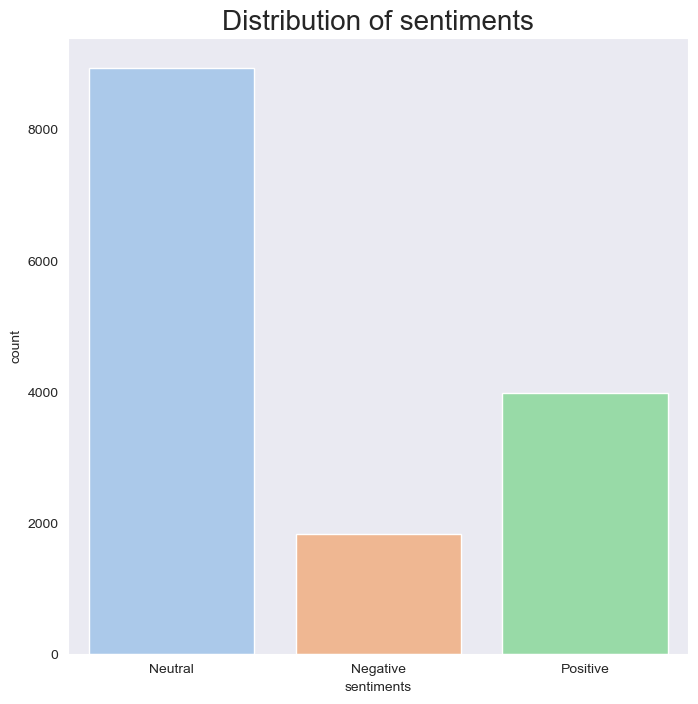

In [29]:
print(df.sentiments.value_counts())
plt.figure(figsize = (8, 8))
ax = sns.countplot(x = 'sentiments', data = df, palette = 'pastel')
ax.set_title(label = 'Distribution of sentiments', fontsize = 20)
ax.set_xticklabels(['Neutral','Negative', 'Positive'], rotation=0)
plt.show()


<Axes: xlabel='sentiments', ylabel='count'>

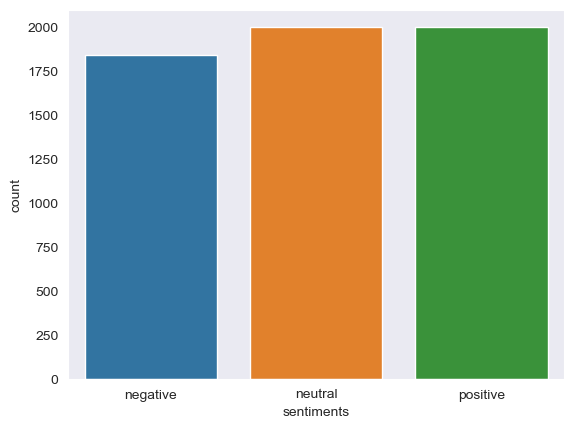

In [6]:
#balance the data
df_pos = df[df.sentiments == 'positive'].head(2000)
df_neu = df[df.sentiments == 'neutral'].head(2000)
df_neg = df[df.sentiments == 'negative']

df_final = pd.concat([df_pos, df_neg], axis = 0)
df_final = pd.concat([df_final, df_neu], axis = 0)

# Convert 'sentiments' column to categorical type
df_final['sentiments'] = pd.Categorical(df_final['sentiments'])

# Plot the countplot
sns.set_style("dark")
sns.countplot(data=df_final, x='sentiments')

In [7]:
#shuffle

df_final = df_final.reindex(np.random.permutation(df_final.index))
df_final.head()

,sentences,sentiments
69,The new plant is planned to have an electricity generation capacity of up to 350 megawatts ( MW ...,neutral
2236,The members of the management team will contribute to the adjustment measures with temporary sal...,positive
8667,"Net cash from operating activities was a negative EUR 0.3 mn , compared to EUR 30.9 mn in 2009 .",negative
12209,"Kiosk and cinema operations have suffered , in particular .",negative
1314,"Poyry Energy GmbH is Austria 's leading engineering and consulting company in the energy , infra...",neutral


In [8]:
df_final['length'] = df_final['sentences'].apply(len)
df_final.head()

,sentences,sentiments,length
69,The new plant is planned to have an electricity generation capacity of up to 350 megawatts ( MW ...,neutral,137
2236,The members of the management team will contribute to the adjustment measures with temporary sal...,positive,112
8667,"Net cash from operating activities was a negative EUR 0.3 mn , compared to EUR 30.9 mn in 2009 .",negative,96
12209,"Kiosk and cinema operations have suffered , in particular .",negative,59
1314,"Poyry Energy GmbH is Austria 's leading engineering and consulting company in the energy , infra...",neutral,180


In [9]:
df_final.length.describe()

count    5841.000000
mean      129.366547
std        55.963152
min         9.000000
25%        85.000000
50%       120.000000
75%       165.000000
max       315.000000
Name: length, dtype: float64

# Removing punctuation and WordCloud Display

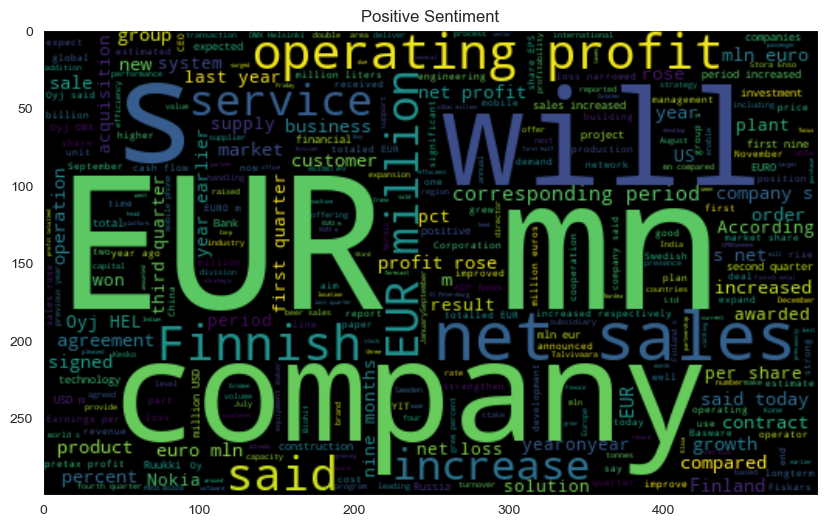

In [10]:
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Creating list of punctuation
punctuation = list(string.punctuation)

# Removing punctuation from the financial text
def remove_punctuation(text):
    for punctuation_mark in punctuation:
        text = text.replace(punctuation_mark, '')
    return text

df_pos['sentences'] = df_pos['sentences'].apply(remove_punctuation)
df_neg['sentences'] = df_neg['sentences'].apply(remove_punctuation)
df_neu['sentences'] = df_neu['sentences'].apply(remove_punctuation)

# Plotting Positive sentiment wordcloud
plt.figure(figsize=(10, 12))
wc = WordCloud(max_words=500, width=500, height=300).generate(" ".join(df_pos.sentences))
plt.imshow(wc, interpolation='bilinear')
plt.title('Positive Sentiment')
plt.show()


Text(0.5, 1.0, 'Negative Sentiment')

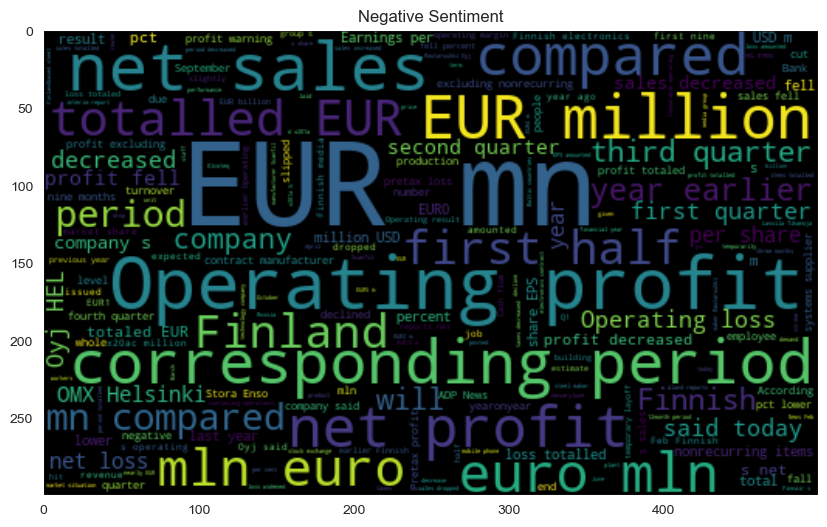

In [11]:

# plotting Negative sentiment wordcoud
plt.figure(figsize = (10,12)) 
wc = WordCloud(max_words = 500 , width = 500 , height = 300).generate(" ".join(df_neg.sentences))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Negative Sentiment')


Text(0.5, 1.0, 'Neutral Sentiment')

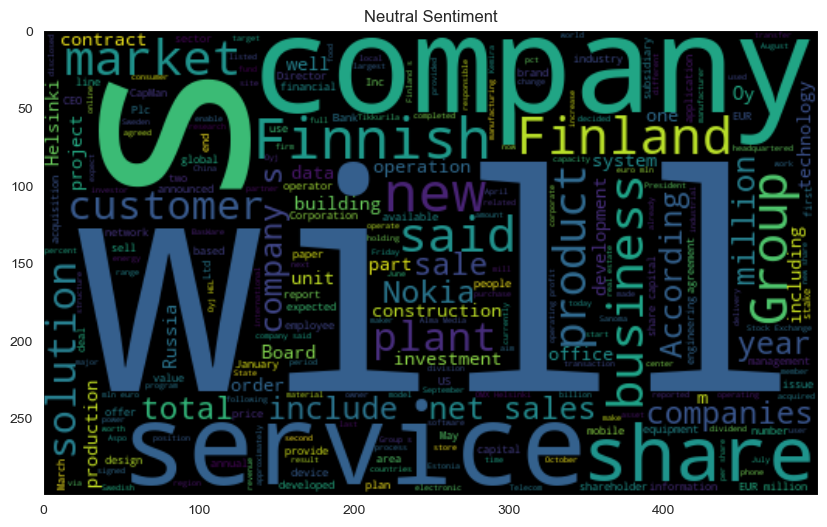

In [12]:

# plotting Neutral sentiment wordcoud
plt.figure(figsize = (10,12)) 
wc = WordCloud(max_words = 500 , width = 500 , height = 300).generate(" ".join(df_neu.sentences))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Neutral Sentiment')

# Data Preprocessing

In [13]:
from nltk.stem import WordNetLemmatizer
import nltk
import re

lemma = WordNetLemmatizer()

# Creating list of possible stopwords from nltk library
stop = stopwords.words('english')

def cleanText(txt):
    # Lowercasing
    txt = txt.lower()
    # Tokenization
    words = nltk.word_tokenize(txt)
    # Lemmatizing the words
    words = ' '.join([lemma.lemmatize(word) for word in words])
    # Removing non-alphabetic characters
    txt = re.sub('[^a-z]',' ', words)
    return txt  

# Applying cleanText function on the 'sentences' column
df_final['cleaned_text'] = df_final['sentences'].apply(cleanText)
df_final.head()


,sentences,sentiments,length,cleaned_text
69,The new plant is planned to have an electricity generation capacity of up to 350 megawatts ( MW ...,neutral,137,the new plant is planned to have an electricity generation capacity of up to megawatt mw ...
2236,The members of the management team will contribute to the adjustment measures with temporary sal...,positive,112,the member of the management team will contribute to the adjustment measure with temporary salar...
8667,"Net cash from operating activities was a negative EUR 0.3 mn , compared to EUR 30.9 mn in 2009 .",negative,96,net cash from operating activity wa a negative eur mn compared to eur mn in
12209,"Kiosk and cinema operations have suffered , in particular .",negative,59,kiosk and cinema operation have suffered in particular
1314,"Poyry Energy GmbH is Austria 's leading engineering and consulting company in the energy , infra...",neutral,180,poyry energy gmbh is austria s leading engineering and consulting company in the energy infra...


# Split Train - Test Data

In [14]:
X=df_final.cleaned_text
y = df_final.sentiments

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y, random_state=0)


# TF-IDF Vectorizer

In [16]:
tfidf_vectorizer = TfidfVectorizer( max_df=0.8, ngram_range=(1,2))
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# Negative word feature

In [17]:
negation_words = ["not", "no", "never", "don't", "can't", "won't", "didn't", "couldn't", 
                  "shouldn't", "isn't", "wasn't", "weren't", "haven't", "hasn't", "hadn't"]

def count_negation_words(text):
    words = nltk.word_tokenize(text)
    negation_count = sum(1 for word in words if word.lower() in negation_words)
    return negation_count

df_final['negation_count'] = df_final['sentences'].apply(count_negation_words)
X_train_nega_count = np.array([count_negation_words(sentence) for sentence in X_train])
X_test_nega_count = np.array([count_negation_words(sentence) for sentence in X_test])

# Sentiwordnet feature

In [18]:
from nltk.corpus import sentiwordnet as swn
def get_sentiment_score(word):
    # Get positive and negative scores for a word from SentiWordNet
    try:
        sentiment = swn.senti_synset(word + '.n.01')
        return sentiment.pos_score() - sentiment.neg_score()
    except:
        return 0

def get_sentiment_feature(sentence):
    # Calculate the average sentiment score for all words in a sentence
    words = nltk.word_tokenize(sentence)
    sentiment_scores = [get_sentiment_score(word) for word in words]
    return np.mean(sentiment_scores)

def combine_features(pos_features, sentiwordnet_features, nega_count):
    # combine features TFIDF, SentiWordnet, Negation_count
    return np.hstack((pos_features.toarray(), sentiwordnet_features.reshape(-1, 1), nega_count.reshape(-1,1)) )


In [19]:
# Extract SentiWordNet features for both training and testing sets
X_train_senti = np.array([get_sentiment_feature(sentence) for sentence in X_train])
X_test_senti = np.array([get_sentiment_feature(sentence) for sentence in X_test])


In [20]:
# combine features
X_train_combined = combine_features(tfidf_train, X_train_senti, X_train_nega_count)
X_test_combined = combine_features(tfidf_test, X_test_senti, X_test_nega_count)


# SVM Model 

In [21]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC

# Training SVM
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(X_train_combined, y_train)

# Predict
y_pred = svm_model.predict(X_test_combined)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Result display
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Report
svm_tfidf_report = classification_report(y_test, y_pred, target_names=['negative', 'positive', 'neutral'])
print(svm_tfidf_report)


Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.88
              precision    recall  f1-score   support

    negative       0.95      0.96      0.95       369
    positive       0.85      0.86      0.86       400
     neutral       0.86      0.83      0.85       400

    accuracy                           0.88      1169
   macro avg       0.88      0.89      0.89      1169
weighted avg       0.88      0.88      0.88      1169



In [54]:
# Select a random subset of examples from the test set
sample_indices = np.random.choice(len(X_test), size=5, replace=False)
sample_X = X_test.iloc[sample_indices]
sample_y_true = y_test.iloc[sample_indices]

# Preprocess the text in the selected examples
sample_X_cleaned = sample_X.apply(cleanText)

# Extract features for the selected examples
sample_tfidf_features = tfidf_vectorizer.transform(sample_X_cleaned)
sample_senti_features = np.array([get_sentiment_feature(sentence) for sentence in sample_X])
sample_nega_count = np.array([count_negation_words(sentence) for sentence in sample_X])
sample_combined_features = combine_features(sample_tfidf_features, sample_senti_features, sample_nega_count)

# Make predictions using the trained SVM model
sample_y_pred = svm_model.predict(sample_combined_features)

# Display the examples along with true and predicted labels
for i in range(len(sample_X)):
    print(f"Example {i + 1}:\n")
    print(f"Text: {sample_X.iloc[i]}\n")
    print(f"True Label: {sample_y_true.iloc[i]}\n")
    print(f"Predicted Label: {sample_y_pred[i]}\n")
    print("="*50)


Example 1:

Text: it also ha potential client in the growing environmental and recycling technology sector  

True Label: neutral

Predicted Label: positive

Example 2:

Text: operating loss totaled eur     mn compared to a profit of eur     mn in the corresponding period in       

True Label: negative

Predicted Label: negative

Example 3:

Text: helsinki thomson financial   share in cargotec fell sharply in early afternoon trade after the cargo handling group posted a surprise drop in april june profit   which overshadowed the large number of new order received during the three month  

True Label: negative

Predicted Label: negative

Example 4:

Text: finnish retail software developer aldata solution oyj reported a net loss of      mln euro        mln for      versus a net profit of     mln euro       mln for       

True Label: negative

Predicted Label: negative

Example 5:

Text: operating result for the    month period decreased from the profit of eur     m while turnover decre

In [33]:
# Example sentence
new_sentence = "The company 's net profit rose 11.4 % on the year to 82.2 million euros in 2005 on sales of 686.5 million euros , 13.8 % up on the year , the company said earlier . ."

# Text preprocessing for the example sentence
cleaned_new_sentence = cleanText(new_sentence)

# Convert the new sentence to TF-IDF vector and extract SentiWordNet, nega_count features
tfidf_new = tfidf_vectorizer.transform([cleaned_new_sentence])
senti_new = get_sentiment_feature(cleaned_new_sentence)
nega_count_new = count_negation_words(cleaned_new_sentence)

# Combine features
combined_features_new = combine_features(tfidf_new, senti_new, np.array([nega_count_new]))

# Predict with the trained SVM model
prediction = svm_model.predict(combined_features_new)

# Print the result
print(f'New sentence: "{new_sentence}"')
print(f'Predicted sentiment: {prediction[0]}')


New sentence: "The company 's net profit rose 11.4 % on the year to 82.2 million euros in 2005 on sales of 686.5 million euros , 13.8 % up on the year , the company said earlier . ."
Predicted sentiment: positive
